<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Regression Trees**


Estimated time needed: **30** minutes


In this exercise session you will use a real dataset to train a regression tree model. The dataset includes information about taxi tip and was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers authorized under the Taxicab & Livery Passenger Enhancement Programs (TPEP/LPEP). You will use the trained model to predict the amount of tip paid. 



## Objectives


After completing this lab you will be able to:


* Perform basic data preprocessing using Scikit-Learn
* Model a regression task using Scikit-Learn
* Train a Decision Tree Regressor model
* Run inference and assess the quality of the trained models


<h2>Introduction</h2>
The dataset used in this exercise session is a subset of the publicly available <a><href='https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page'>TLC Dataset</a> (all rights reserved by Taxi & Limousine Commission (TLC), City of New York). The prediction of the tip amount can be modeled as a regression problem. To train the model you can use part of the input dataset and the remaining data can be used to assess the quality of the trained model.
    <br>
</div>


<div id="import_libraries">
    <h2>Import Libraries</h2>
</div>


Make sure the libraries required are available by executing the cell below.


In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn

Import the libraries we need to use in this lab


In [2]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

<div id="dataset_analysis">
    <h2>Dataset Analysis</h2>
</div>


In this section you will read the dataset in a Pandas dataframe and visualize its content. You will also look at some data statistics.

Note: A Pandas dataframe is a two-dimensional, size-mutable, potentially heterogeneous tabular data structure. For more information: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html.


In [3]:
# read the input data
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/pu9kbeSaAtRZ7RxdJKX9_A/yellow-tripdata.csv'
raw_data = pd.read_csv(url)
raw_data

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,mta_tax,tolls_amount,improvement_surcharge,tip_amount
0,2,1,17.63,2,1,132,164,1,70.0,0.5,6.94,1,16.54
1,2,1,19.52,2,1,132,236,1,70.0,0.5,6.94,1,16.19
2,2,1,17.81,2,1,132,48,1,70.0,0.5,6.94,1,12.00
3,2,2,19.30,2,1,132,148,1,70.0,0.5,0.00,1,5.00
4,2,1,18.75,2,1,132,234,1,70.0,0.5,6.94,1,10.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41197,2,1,16.94,2,1,132,164,1,70.0,0.5,6.94,1,5.00
41198,2,4,19.83,2,1,132,166,1,70.0,0.5,6.94,1,8.00
41199,2,1,17.31,2,1,132,137,1,70.0,0.5,6.94,1,8.00
41200,2,1,17.28,2,1,132,233,1,70.0,0.5,6.94,1,16.19


In [5]:
raw_data.info()
raw_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41202 entries, 0 to 41201
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               41202 non-null  int64  
 1   passenger_count        41202 non-null  int64  
 2   trip_distance          41202 non-null  float64
 3   RatecodeID             41202 non-null  int64  
 4   store_and_fwd_flag     41202 non-null  int64  
 5   PULocationID           41202 non-null  int64  
 6   DOLocationID           41202 non-null  int64  
 7   payment_type           41202 non-null  int64  
 8   fare_amount            41202 non-null  float64
 9   mta_tax                41202 non-null  float64
 10  tolls_amount           41202 non-null  float64
 11  improvement_surcharge  41202 non-null  int64  
 12  tip_amount             41202 non-null  float64
dtypes: float64(5), int64(8)
memory usage: 4.1 MB


VendorID                 0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
mta_tax                  0
tolls_amount             0
improvement_surcharge    0
tip_amount               0
dtype: int64

Each row in the dataset represents a taxi trip. As shown above, each row has 13 variables. One of the variables is `tip_amount` which will be the target variable. Your objective will be to train a model that uses the other variables to predict the value of the `tip_amount` variable.


To understand the dataset a little better, let us plot the correlation of the target variable against the input variables.


<Axes: >

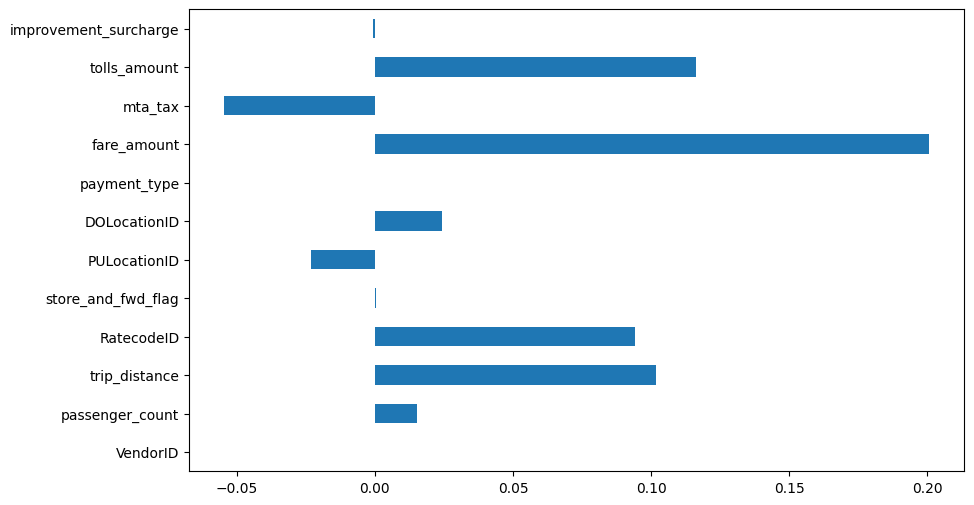

In [6]:
correlation_values = raw_data.corr()['tip_amount'].drop('tip_amount')
correlation_values.plot(kind='barh', figsize=(10, 6))

This shows us that the input features `payment_type`, `VendorID`, `store_and_fwd_flag` and `improvement_surcharge` have little to no correlation with the target variable.


<div id="dataset_preprocessing">
    <h2>Dataset Preprocessing</h2>
</div>


You will now prepare the data for training by applying normalization to the input features.


In [7]:
# extract the labels from the dataframe
y = raw_data[['tip_amount']].values.astype('float32')

# drop the target variable from the feature matrix
proc_data = raw_data.drop(['tip_amount'], axis=1)

# get the feature matrix used for training
X = proc_data.values

# normalize the feature matrix
X = normalize(X, axis=1, norm='l1', copy=False)

<div id="dataset_split">
    <h2>Dataset Train/Test Split</h2>
</div>


Now that the dataset is ready for building the classification models, you need to first divide the pre-processed dataset into a subset to be used for training the model (the train set) and a subset to be used for evaluating the quality of the model (the test set).


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

<div id="dt_sklearn">
    <h2>Build a Decision Tree Regressor model with Scikit-Learn</h2>
</div>


Regression Trees are implemented using `DecisionTreeRegressor`.

The important parameters of the model are:

`criterion`: The function used to measure error, we use 'squared_error'.

`max_depth` - The maximum depth the tree is allowed to take; we use 8.


In [23]:
# import the Decision Tree Regression Model from scikit-learn
from sklearn.tree import DecisionTreeRegressor

# for reproducible output across multiple function calls, set random_state to a given integer value
dt_reg = DecisionTreeRegressor(criterion = 'squared_error',
                               max_depth=4, 
                               random_state=35)

Now lets train our model using the `fit` method on the `DecisionTreeRegressor` object providing our training data


In [24]:
dt_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, random_state=35)

<div id="dt_sklearn_snapml">
    <h2>Evaluate the Scikit-Learn and Snap ML Decision Tree Regressor Models</h2>
</div>


To evaluate our dataset we will use the `score` method of the `DecisionTreeRegressor` object providing our testing data, this number is the $R^2$ value which indicates the coefficient of determination. We will also evaluate the Mean Squared Error $(MSE)$ of the regression output with respect to the test set target values. High $R^2$ and low $MSE$ values are expected from a good regression model.


In [25]:
# run inference using the sklearn model
y_pred = dt_reg.predict(X_test)

# evaluate mean squared error on the test dataset
mse_score = mean_squared_error(y_test, y_pred)
print('MSE score : {0:.3f}'.format(mse_score))

r2_score = dt_reg.score(X_test,y_test)
print('R^2 score : {0:.3f}'.format(r2_score))

MSE score : 24.468
R^2 score : 0.031


In [31]:
type(y_pred)

numpy.ndarray

ValueError: x and y must be the same size

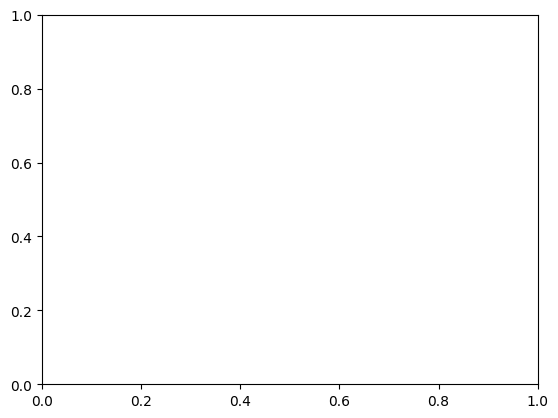

In [32]:
plt.scatter(range(len(y_pred)).index,y_pred)
plt.show()

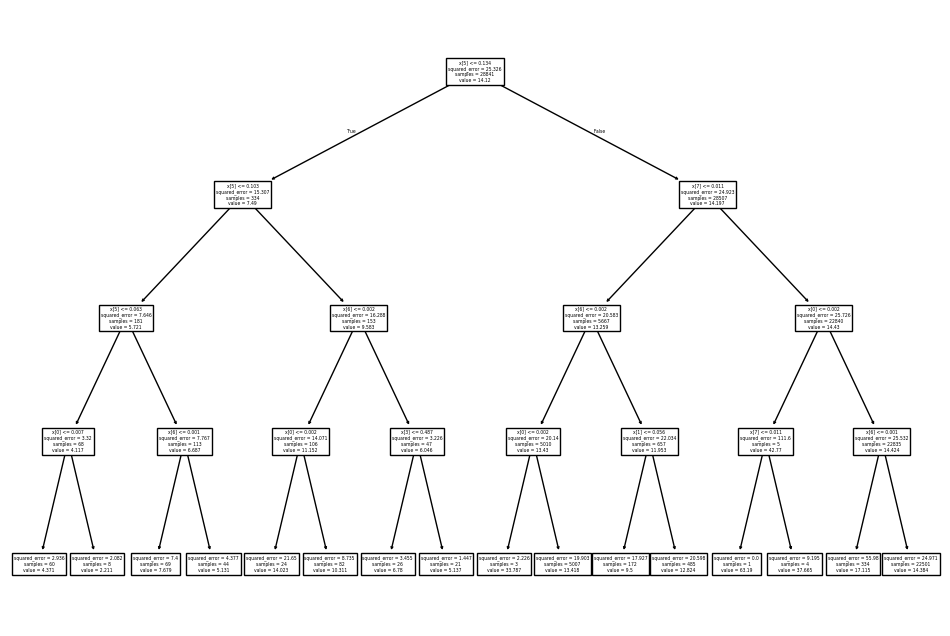

In [26]:
from sklearn.tree import plot_tree
plt.figure(figsize=(12, 8))
plot_tree(dt_reg)
plt.show()

## Practice


Q1. What if we change the max_depth to 12? How would the $MSE$ and $R^2$ be affected? 


In [12]:
dt_reg = DecisionTreeRegressor(criterion = 'squared_error',
                               max_depth=12, 
                               random_state=35)
dt_reg.fit(X_train, y_train)
# run inference using the sklearn model
y_pred = dt_reg.predict(X_test)

# evaluate mean squared error on the test dataset
mse_score = mean_squared_error(y_test, y_pred)
print('MSE score : {0:.3f}'.format(mse_score))

r2_score = dt_reg.score(X_test,y_test)
print('R^2 score : {0:.3f}'.format(r2_score))

MSE score : 26.459
R^2 score : -0.047


<details><summary>Click here for the solution</summary>
MSE is noted to be increased by increasing the max_depth of the tree. This may be because of the model having excessive parameters due to which it overfits to the training data, making the performance on the testing data poorer. Another important observation would be that the model gives a <b>negative</b> value of $R^2$. This again indicates that the prediction model created does a very poor job of predicting the values on a test set.
</details>


Q2. Identify the top 3 features with the most effect on the `tip_amount`.


In [13]:
correlation_values = raw_data.corr()['tip_amount'].drop('tip_amount')
abs(correlation_values).sort_values(ascending=False)[:3]

fare_amount      0.200638
tolls_amount     0.116172
trip_distance    0.101819
Name: tip_amount, dtype: float64

<details><summary>Click here for the solution</summary>

```python    
correlation_values = raw_data.corr()['tip_amount'].drop('tip_amount')
abs(correlation_values).sort_values(ascending=False)[:3]

```
<br>
As is evident from the output, Fare amount, toll amount and trip distance are the top features affecting the tip amount, which make logical sense.
</details>


Q3. Since we identified 4 features which are not correlated with the target variable, try removing these variables from the input set and see the effect on the $MSE$ and $R^2$ value.


In [14]:
# drop the target variable from the feature matrix
proc_data = raw_data.drop(['tip_amount','payment_type', 'VendorID', 'store_and_fwd_flag', 'improvement_surcharge'], axis=1)

# get the feature matrix used for training
X = proc_data.values

# normalize the feature matrix
X = normalize(X, axis=1, norm='l1', copy=False)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# import the Decision Tree Regression Model from scikit-learn
from sklearn.tree import DecisionTreeRegressor

# for reproducible output across multiple function calls, set random_state to a given integer value
dt_reg = DecisionTreeRegressor(criterion = 'squared_error',
                               max_depth=8, 
                               random_state=35)

dt_reg.fit(X_train, y_train)

# run inference using the sklearn model
y_pred = dt_reg.predict(X_test)

# evaluate mean squared error on the test dataset
mse_score = mean_squared_error(y_test, y_pred)
print('MSE score : {0:.3f}'.format(mse_score))

r2_score = dt_reg.score(X_test,y_test)
print('R^2 score : {0:.3f}'.format(r2_score))

MSE score : 24.709
R^2 score : 0.022


<details><summary>Click here for the solution</summary>

```python
raw_data = raw_data.drop(['payment_type', 'VendorID', 'store_and_fwd_flag', 'improvement_surcharge'], axis=1)

# Execute all the cells of the lab after modifying the raw data.
```
<br>
The MSE and $R^2$ values does not change significantly, showing that there is minimal affect of these parameters on the final regression output.
</details>


Q4. Check the effect of **decreasing** the `max_depth` parameter to 4 on the $MSE$ and $R^2$ values.


<details><summary>Click here for the solution</summary>
You will note that the MSE value decreases and $R^2$ value increases, meaning that the choice of `max_depth=4` may be more suited for this dataset.
</details>


### Congratulations! You're ready to move on to your next lesson!

## Author
<a href="https://www.linkedin.com/in/abhishek-gagneja-23051987/" target="_blank">Abhishek Gagneja</a>

### Other Contributors
<a href="https://www.linkedin.com/in/jpgrossman/" target="_blank">Jeff Grossman</a>  
 
<h3 align="center"> © IBM Corporation. All rights reserved. <h3/>

 
<!--
## Change Log
 
 
|  Date (YYYY-MM-DD) |  Version       | Changed By     | Change Description                  |
|---|---|---|---|
| 2024-10-31         | 3.0            | Abhishek Gagneja  | Rewrite                             |
| 2020-11-03         | 2.1            | Lakshmi        | Made changes in URL                 |
| 2020-11-03         | 2.1            | Lakshmi        | Made changes in URL                 |
| 2020-08-27         | 2.0            | Lavanya        | Moved lab to course repo in GitLab  |
|   |   |   |   |
